# Generate test comparison data

Notebook with which the comparison data for the tests is generated, in case the old results are no longer valid.

In [13]:
import pandas as pd
import sys
sys.path.append('../../anduryl')
import anduryl
import numpy as np
from hkvpy import plotting
import seaborn as sns
import matplotlib.pyplot as plt

plotting.set_rcparams()

### Validation table

In [6]:
# Case name - file
files = {
    'Arkansas': 'Arkansas.mat',
    'Arsenic': 'arsenic d-r.mat',
    'ATCEP': 'ATCEP Error.mat',
    'Biol_Agent': 'Biol agents.mat',
    'CDC_ROI': 'CDC ROI Final.mat',
    'CoveringKids': 'CoveringKids.mat',
    'create-vicki': 'create.mat',
    'CWD': 'cwd.mat',
    'Daniela': 'Daniela.mat',
    'DCPN_Fistula': 'dcpn_fistula.mat',
    'eBPP': 'ebbp.mat',
    'Eff_Erup': 'EffusiveErupt.mat',
    'Erie_Carp': 'Erie Carps.mat',
    'FCEP': 'FCEP Error.mat',
    'Florida': 'Florida.mat',
    'Gerstenberger': 'Gerstenberger.mat',
    'GL_NIS': 'gl-nis.mat',
    'Goodheart': 'Goodheart.mat',
    'Hemopilia': 'Hemophilia.mat',
    'IceSheets': 'IceSheet2012.mat',
    'Illinois': 'Illinois.mat',
    'Liander': 'liander.mat',
    'Nebraska': 'Nebraska.mat',
    'Obesity': 'obesity_ms.mat',
    'PHAC_T4': 'PHAC 2009 final.mat',
    'San_Diego': 'San Diego.mat',
    'Sheep': 'Sheep Scab.mat',
    'SPEED': 'speed.mat',
    'TDC': 'tdc.mat',
    'Tobacco': 'tobacco.mat',
    'Topaz': 'Topaz.mat',
    'UMD_NREMOVAL': 'umd_nremoval.mat',
    'Washington': 'Washington.mat'
}


In [7]:
# Load Excalibur table as format
validation_table = pd.read_csv('../test/data/Excalibur.csv', sep=';', header=[0, 1], index_col=0)
validation_table.head()

Characteristics Characteristics      Equal weight              \
Study                      #Exp #Cal           Sa   Inf  Comb   
Arkansas                      4   10         0.39  0.20  0.08   
Arsenic                       9   10         0.06  1.10  0.07   
ATCEP                         5   10         0.12  0.25  0.03   
Biol_Agent                   12   12         0.41  0.24  0.10   
CDC_ROI                      20   10         0.23  1.23  0.29   

Characteristics PW Non-optimized             PW Global             PW Item  \
Study                         Sa   Inf  Comb        Sa   Inf  Comb      Sa   
Arkansas                    0.50  0.34  0.17      0.50  0.34  0.17    0.50   
Arsenic                     0.04  1.68  0.06      0.04  2.74  0.10    0.04   
ATCEP                       0.68  0.23  0.16      0.68  0.23  0.16    0.24   
Biol_Agent                  0.41  0.43  0.18      0.68  0.61  0.41    0.68   
CDC_ROI                     0.39  1.35  0.52      0.72  2.31  1.66    0.72   

Characteristics             Best Expert              
Study             Inf  Comb          Sa   Inf  Comb  
Arkansas         0.52  0.26        0.07  0.41  0.03  
Arsenic          2.74  0.10        0.04  2.74  0.10  
ATCEP            0.38  0.09        0.10  0.50  0.05  
Biol_Agent       0.66  0.45        0.31  1.00  0.31  
CDC_ROI          2.31  1.66        0.72  2.31  1.66

In [8]:
anduryl_piecewiselinear = validation_table.copy()
anduryl_piecewiselinear_sas = {}
anduryl_piecewiselinear_infos = {}

for key, file in files.items():
    
    anduryl.core.experts.USE_METALOG = False
    anduryl.core.experts.USE_PWL_CONTINUOUS = False

    project = anduryl.Project()
    file = file.replace('.mat', '')
    project.io.load_excalibur(f'../cases/{file}.dtt', f'../cases/{file}.rls')
    if project.assessments.quantiles != [0.05, 0.5, 0.95]:
        anduryl_piecewiselinear.drop(key, axis=0, inplace=True)
        continue
        
    project.calculate_decision_maker(weight_type='item', overshoot=0.1, exp_id='DM1', exp_name='Item opt.')
    itemopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear.loc[key, 'PW Item'] = itemopt
    print(sum(project.experts.calibration[:-1] > 0.05))

    project.calculate_decision_maker(weight_type='global', overshoot=0.1, exp_id='DM2', exp_name='Global opt.')
    globopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear.loc[key, 'PW Global'] = globopt

    project.calculate_decision_maker(weight_type='global', alpha=0.0, overshoot=0.1, exp_id='DM3', exp_name='Global Non-opt.')
    globnonopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear.loc[key, 'PW Non-optimized'] = globnonopt
    anduryl_piecewiselinear_sas[key] = project.experts.calibration[:-3].copy()
    anduryl_piecewiselinear_infos[key] = project.experts.info_total[:-3].copy()

    project.calculate_decision_maker(weight_type='equal', overshoot=0.1, exp_id='DM4', exp_name='Equal')
    equal = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear.loc[key, 'Equal weight'] = equal

    imax = np.argmax([project.experts.comb_score[i] for i in project.experts.actual_experts])
    ibest = project.experts.actual_experts[imax]
    best_exp = np.round([project.experts.calibration[ibest], project.experts.info_real[ibest], project.experts.info_real[ibest] * project.experts.calibration[ibest]], 2)
    anduryl_piecewiselinear.loc[key, 'Best Expert'] = best_exp
    
#     print(key, globnonopt, 'global non opt')
#     print(key, equal, 'Equal weight')
#     print(key, best_exp, 'Best Expert')
#     print()
    
#     break

0
1
2
0
5
2
7
3
9
2
2
2
3
0
0
1
1
3
2
2


In [9]:
anduryl_piecewiselinear_cont = validation_table.copy()
anduryl_piecewiselinear_cont_sas = {}
anduryl_piecewiselinear_cont_infos = {}

for key, file in files.items():
    
    anduryl.core.experts.USE_METALOG = False
    anduryl.core.experts.USE_PWL_CONTINUOUS = True

    project = anduryl.Project()
    file = file.replace('.mat', '')
    project.io.load_excalibur(f'../cases/{file}.dtt', f'../cases/{file}.rls')
    if project.assessments.quantiles != [0.05, 0.5, 0.95]:
        anduryl_piecewiselinear_cont.drop(key, axis=0, inplace=True)
        continue
        
    project.calculate_decision_maker(weight_type='item', overshoot=0.1, exp_id='DM1', exp_name='Item opt.')
    itemopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear_cont.loc[key, 'PW Item'] = itemopt
    print(sum(project.experts.calibration.copy()[:-1] > 0.05))

    project.calculate_decision_maker(weight_type='global', overshoot=0.1, exp_id='DM2', exp_name='Global opt.')
    globopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear_cont.loc[key, 'PW Global'] = globopt

    project.calculate_decision_maker(weight_type='global', alpha=0.0, overshoot=0.1, exp_id='DM3', exp_name='Global Non-opt.')
    globnonopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear_cont.loc[key, 'PW Non-optimized'] = globnonopt
    anduryl_piecewiselinear_cont_sas[key] = project.experts.calibration[:-3].copy()
    anduryl_piecewiselinear_cont_infos[key] = project.experts.info_total[:-3].copy()

    project.calculate_decision_maker(weight_type='equal', overshoot=0.1, exp_id='DM4', exp_name='Equal')
    equal = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_piecewiselinear_cont.loc[key, 'Equal weight'] = equal

    imax = np.argmax([project.experts.comb_score[i] for i in project.experts.actual_experts])
    ibest = project.experts.actual_experts[imax]
    best_exp = np.round([project.experts.calibration[ibest], project.experts.info_real[ibest], project.experts.info_real[ibest] * project.experts.calibration[ibest]], 2)
    anduryl_piecewiselinear_cont.loc[key, 'Best Expert'] = best_exp
    
#     print(key, globnonopt, 'global non opt')
#     print(key, equal, 'Equal weight')
#     print(key, best_exp, 'Best Expert')
#     print()
    
#     break

5
3
8
7
9
3
9


d:\Documents\GitHub\anduryl\notebooks\../../anduryl\anduryl\core\experts.py:774: RuntimeWarning: invalid value encountered in true_divide
  weights[:, :, total_idx] /= weights[:, :, total_idx].sum(axis=1)[:, None, :]
d:\Documents\GitHub\anduryl\notebooks\../../anduryl\anduryl\core\calculate.py:102: RuntimeWarning: invalid value encountered in true_divide
  weights[:, :, iq] /= numerator


9
10
3
6
6
7
5
6
10
7
9
7
5


In [10]:
anduryl_metalog = validation_table.copy()
anduryl_metalog_sas = {}
anduryl_metalog_infos = {}

import cProfile, pstats, io
from pstats import SortKey

pr = cProfile.Profile()
pr.enable()

for key, file in files.items():
    
    anduryl.core.experts.USE_METALOG = True
    anduryl.core.experts.USE_PWL_CONTINUOUS = False

    project = anduryl.Project()
    file = file.replace('.mat', '')
    project.io.load_excalibur(f'../cases/{file}.dtt', f'../cases/{file}.rls')
    if project.assessments.quantiles != [0.05, 0.5, 0.95]:
        anduryl_metalog.drop(key, axis=0, inplace=True)
        continue
        
    project.calculate_decision_maker(weight_type='item', overshoot=0.1, exp_id='DM1', exp_name='Item opt.')
    print(sum(project.experts.calibration[:-1] > 0.05))
    
    itemopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_metalog.loc[key, 'PW Item'] = itemopt

    project.calculate_decision_maker(weight_type='global', overshoot=0.1, exp_id='DM2', exp_name='Global opt.')
    globopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_metalog.loc[key, 'PW Global'] = globopt

    project.calculate_decision_maker(weight_type='global', alpha=0.0, overshoot=0.1, exp_id='DM3', exp_name='Global Non-opt.')
    globnonopt = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_metalog.loc[key, 'PW Non-optimized'] = globnonopt
    anduryl_metalog_sas[key] = project.experts.calibration[:-3].copy()
    anduryl_metalog_infos[key] = project.experts.info_total[:-3].copy()

    project.calculate_decision_maker(weight_type='equal', overshoot=0.1, exp_id='DM4', exp_name='Equal')
    equal = np.round([project.experts.calibration[-1], project.experts.info_real[-1], project.experts.info_real[-1] * project.experts.calibration[-1]], 2)
    anduryl_metalog.loc[key, 'Equal weight'] = equal

    imax = np.argmax([project.experts.comb_score[i] for i in project.experts.actual_experts])
    ibest = project.experts.actual_experts[imax]
    best_exp = np.round([project.experts.calibration[ibest], project.experts.info_real[ibest], project.experts.info_real[ibest] * project.experts.calibration[ibest]], 2)
    anduryl_metalog.loc[key, 'Best Expert'] = best_exp
    
#     print(key, globnonopt, 'global non opt')
#     print(key, equal, 'Equal weight')
#     print(key, best_exp, 'Best Expert')
#     print()

    print(key)
    
#     break
    
pr.disable()

pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
with open("D:/Documents/profile.txt", "w") as f:
    f.write(s.getvalue())

3
Arsenic
1
ATCEP
6
Biol_Agent
3
create-vicki
7
CWD
3
Daniela
9
eBPP
6
Eff_Erup
10
Erie_Carp
2
FCEP
3
GL_NIS
5
Goodheart
4
IceSheets
4
Liander
2
PHAC_T4
7
Sheep
5
SPEED
8
TDC
5
Topaz
5
UMD_NREMOVAL


In [11]:
length = max([len(v) for v in anduryl_piecewiselinear_sas.values()])
for key, arr in anduryl_piecewiselinear_sas.items():
    full_arr = np.full(length, np.nan)
    full_arr[:len(arr)] = arr
    anduryl_piecewiselinear_sas[key] = full_arr

for key, arr in anduryl_piecewiselinear_cont_sas.items():
    full_arr = np.full(length, np.nan)
    full_arr[:len(arr)] = arr
    anduryl_piecewiselinear_cont_sas[key] = full_arr
    
for key, arr in anduryl_metalog_sas.items():
    full_arr = np.full(length, np.nan)
    full_arr[:len(arr)] = arr
    anduryl_metalog_sas[key] = full_arr



Text(0.05, 0.95, '-0.22')

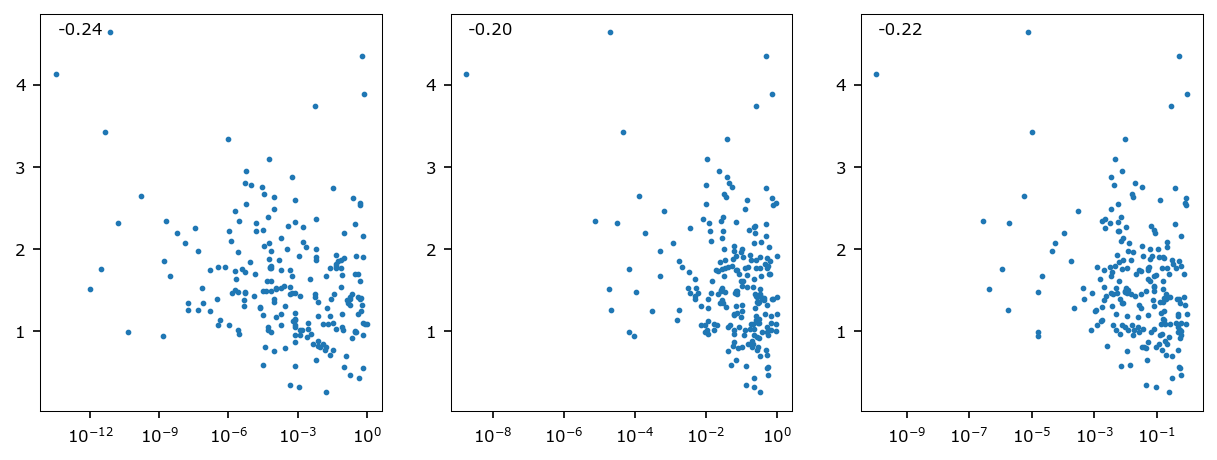

In [38]:
from scipy.stats import spearmanr

fig, axs = plt.subplots(ncols=3, figsize=(10, 3.5))
for ax in axs:
    ax.set_xscale('log')
#     ax.set_xlim(1e-8, 1)

ax = axs[0]
cali = np.concatenate(list(anduryl_piecewiselinear_sas.values()))
cali = cali[~np.isnan(cali)]
info = np.concatenate(list(anduryl_piecewiselinear_infos.values()))
ax.scatter(cali, info, s=3)
ax.annotate(text=f'{spearmanr(cali, info).correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

ax = axs[1]
cali = np.concatenate(list(anduryl_piecewiselinear_cont_sas.values()))
cali = cali[~np.isnan(cali)]
info = np.concatenate(list(anduryl_piecewiselinear_cont_infos.values()))
ax.scatter(cali, info, s=3)
ax.annotate(text=f'{spearmanr(cali, info).correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

ax = axs[2]
cali = np.concatenate(list(anduryl_metalog_sas.values()))
cali = cali[~np.isnan(cali)]
info = np.concatenate(list(anduryl_metalog_infos.values()))
ax.scatter(cali, info, s=3)
ax.annotate(text=f'{spearmanr(cali, info).correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

In [8]:
writer = pd.ExcelWriter('tables.xlsx', engine='xlsxwriter')

anduryl_piecewiselinear.to_excel(writer, sheet_name='Table PWL binned')
pd.DataFrame.from_dict(anduryl_piecewiselinear_sas).to_excel(writer, sheet_name='SA PWL binned', index=False)

anduryl_piecewiselinear_cont.to_excel(writer, sheet_name='Table PWL cont')
pd.DataFrame.from_dict(anduryl_piecewiselinear_cont_sas).to_excel(writer, sheet_name='SA PWL cont', index=False)

anduryl_metalog.to_excel(writer, sheet_name='Table Metalog')
pd.DataFrame.from_dict(anduryl_metalog_sas).to_excel(writer, sheet_name='SA Metalog', index=False)

# Apply conditional formatting
workbook = writer.book

redformat = workbook.add_format({'bg_color': '#FFC7CE'})
greenformat = workbook.add_format({'bg_color': '#C6EFCE', 'bold': 1})

for key, sheet in workbook.sheetnames.items():
    if 'SA' in key:
        sheet.conditional_format(1, 0, length, len(anduryl_metalog_sas), 
                                 {'type': 'cell', 'criteria': '>=', 'value': 0.05, 'format': greenformat})
        sheet.conditional_format(1, 0, length, len(anduryl_metalog_sas), 
                                 {'type': 'cell', 'criteria': 'between', 'minimum': 1e-30, 'maximum': 0.05, 'format': redformat})

writer.close()

PermissionError: [Errno 13] Permission denied: 'tables.xlsx'

In [ ]:
pd.DataFrame.from_dict(anduryl_piecewiselinear_cont_sas).round(3)
# pd.DataFrame.from_dict(anduryl_piecewiselinear_sas).round(3)
pd.DataFrame.from_dict(anduryl_metalog_sas).round(3)

In [ ]:
cols = ['Equal weight', 'PW Non-optimized', 'PW Global', 'PW Item', 'Best Expert']

fig, axs = plt.subplots(5, 5, figsize=(8, 8), sharex=True, sharey=True)

# for comb in [
#     ['Equal weight', 'PW Non-optimized'],
#     ['PW Non-optimized',],
#     ['Equal weight'],
# ]

# import seaborn as sns

score = 'Sa'

maxlim = {
    'Sa': 1,
    'Inf': 3,
    'Comb': 1.5
}[score]

# data1 = anduryl_piecewiselinear.loc[:, (slice(None), score)].copy()
# data1.columns = data1.columns.get_level_values(0)

key1 = 'PWL Cont (SA from CVM)'
data1 = anduryl_piecewiselinear_cont.loc[:, (slice(None), score)].copy()
data1.columns = data1.columns.get_level_values(0)

key2 = 'Metalog (SA from CVM)'
data2 = anduryl_metalog.loc[:, (slice(None), score)].copy()
data2.columns = data2.columns.get_level_values(0)

key3 = 'PWL binned (SA from entropy)'
data3 = anduryl_piecewiselinear.loc[:, (slice(None), score)].copy()
data3.columns = data3.columns.get_level_values(0)


# maxlim = max(data1.max().max(), data2.max().max()) * 1.05

for i in range(5):
    for j in range(5):
        ax = axs[i, j]
        ax.grid()
        if i <= j:
            fig.delaxes(ax)
            continue
#             ax.set_xlim(0, 1.5)
        else:
            ax.axis((0, maxlim, 0, maxlim))
            ax.scatter(data2[cols[j]], data2[cols[i]], s=3, color='C0', label=key2)
            ax.scatter(data3[cols[j]], data3[cols[i]], s=3, color='C1', label=key3, marker='x')
            ax.plot([0, maxlim], [0, maxlim], color='k', lw=0.5, ls='-', zorder=-10)
            
            if i == 4:
                ax.set_xlabel(cols[j])
            if j == 0:
                ax.set_ylabel(cols[i])

           
plt.tight_layout(pad=0.5)
axs[1, 0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title=score+' score')
        

In [ ]:
fig, axs = plt.subplots(figsize=(10, 6), ncols=len(cols), nrows=3)
fig.set_facecolor('white')

datas = [data1, data2, data3]
keys = [key1, key2, key3]

for i, comb in enumerate([[0, 1], [1, 2], [0, 2]]):
    axrow = axs[i]
    i1, i2 = comb
    for ax, col in zip(axrow, cols):
        ax.set_aspect(1.0)
        ax.plot([0,1], [0,1], color='k', ls='--')
#         ax.axis((0, 1, 0, 1))

        ax.scatter(datas[i1][col], datas[i2][col], color='C0', s=5)

        ax.set(title=col, xlabel=keys[i1], ylabel=keys[i2])
        
        ax.axhline(0.05, ls=':', color='C3')
        ax.axvline(0.05, ls=':', color='C3')

fig.tight_layout()
    
#     sns.kdeplot(data=data2[col], ax=ax)
#     sns.histplot(data=data1[col], ax=ax)
#     sns.histplot(data=data2[col], ax=ax)

In [ ]:
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

xgrid = np.linspace(0, maxlim, 100)

fig, axs = plt.subplots(figsize=(10, 3), ncols=len(cols))
for ax, col in zip(axs, cols):
    
#     y = kde_scipy(data1[col], xgrid, bandwidth=0.05)
#     ax.plot(xgrid, y)
    ax.hist(data1[col], color='C0', alpha=0.5, density=True, range=(0, 1))
    
#     y = kde_scipy(data2[col], xgrid, bandwidth=0.05)
#     ax.plot(xgrid, y)
    ax.hist(data2[col], color='C1', alpha=0.5, density=True, range=(0, 1))
    ax.set(xlabel=col)

fig.tight_layout()
    
#     sns.kdeplot(data=data2[col], ax=ax)
#     sns.histplot(data=data1[col], ax=ax)
#     sns.histplot(data=data2[col], ax=ax)